In [1]:
import pandas as pd
import numpy as np
import nltk
import re

In [2]:
netflix_shows = pd.read_csv("netflix_titles_v2.csv")
posts = pd.read_csv("Netflix_Posts.csv")
comments = pd.read_csv("Netflix_Comments.csv")

## 1. Minor Data Preprocessing For Data Exploration

I will be preprocessing the comments only for Initial Data Exploration (Bigrams, Wordcloud):
* Dropping empty comments
* Removing links
* Removing punctuation
* Removing \n, \t, etc.

In [3]:
posts.head()

,Submission,Netflix_Title,Genres,Body,URL,Upvotes,Time,Key
0,Netflix executives say the success of 'Bright'...,Bright,"Action & Adventure, Sci-Fi & Fantasy",NaN,https://www.reddit.com/r/netflix/comments/7t2f...,6802,2018-01-26 18:11:49,0
1,Netflix Fires Kevin Spacey from ‘House of Cards’,House of Cards,"TV Dramas, TV Thrillers",NaN,https://www.reddit.com/r/netflix/comments/7ao8...,6504,2017-11-04 15:47:43,1
2,Netflix has Cloverfield 3,Cloverfield,"Action & Adventure, Horror Movies, Sci-Fi & Fa...",Edit: Streaming starts post game,https://www.reddit.com/r/netflix/comments/7vav...,5597,2018-02-05 13:23:43,2
3,The Witcher is Netflix's highest rated series,The Witcher,"TV Action & Adventure, TV Dramas, TV Mysteries",https://www.forbes.com/sites/paultassi/2019/12...,https://www.reddit.com/r/netflix/comments/eekm...,4891,2019-12-24 02:30:46,3
4,"Netflix has won its first Oscar, for Icarus",Icarus,"Documentaries, Sports Movies",NaN,https://www.reddit.com/r/netflix/comments/8238...,4632,2018-03-05 17:03:47,4


In [4]:
posts.shape

(415, 8)

In [5]:
comments.head()

,Reply,Upvote,Time,Key
0,I didn't go into Bright expecting a cinematic ...,2079,2018-01-26 21:23:11,0
1,It was pretty good. It was a solid B. Pretty m...,1529,2018-01-26 18:59:11,0
2,"I enjoyed it, I would watch another. It did n...",244,2018-01-27 00:16:08,0
3,This is a pretty terrible argument. There no f...,25,2018-01-27 04:42:08,0
4,Everything was great about it except the plot....,149,2018-01-26 23:37:54,0


In [6]:
comments.shape

(57732, 4)

1.1 Dropping empty comments

In [7]:
comments.dropna(subset = ["Reply"], inplace = True)

In [8]:
# Resetting index
comments = comments.reset_index(drop = True)

1.2 Remove links

In [9]:
comments.Reply = comments.Reply.apply(lambda x: re.sub(r"\(?http\S+", "", x))

1.3 Remove punctuation

In [10]:
comments.Reply = comments.Reply.apply(lambda x: re.sub(r"[^\w\s]", "", x))

1.4 Removing \n, \t, etc. characters that do not help with prediction, but might link 2 words together, making them indistinguishable from one another.

In [11]:
comments.Reply = comments.Reply.apply(lambda x: " ".join(nltk.word_tokenize(x)))

From the MSA Discord, I found that if you removed the \n, \t, etc. before removing punctuation, the code would be incorrectly separating "don't" into "do" and "n't". However, this problem is easily avoided if you just remove the punctuation first - no need to use the below code to replace "n't" with "not".

In [12]:
# posts.Submission = posts.Submission.apply(lambda x: x.replace(" n't ", " not "))
# posts.Body = posts.Body.apply(lambda x: x.replace(" n't ", " not "))
# comments.Reply = comments.Reply.apply(lambda x: x.replace(" n't ", " not "))

#### 1.5 Bigrams

In [13]:
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

In [14]:
# Joins all comments separated by a ". " into a SINGLE string
# Trying it on all 57729 comments
all_text = comments.Reply.str.cat(sep = ". ")
all_text[:200]

'I didnt go into Bright expecting a cinematic masterpiece I was expecting Training Day with elves and magic which is exactly what it delivered. It was pretty good It was a solid B Pretty much what I ex'

In [15]:
# Bigrams only accept lists, so we tokenize our single string
all_text = nltk.word_tokenize(all_text)

In [17]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

bigrams_50 = common_bigrams(all_text, 50, 10)
print(bigrams_50)

[('Rotten', 'Tomatoes'), ('sci', 'fi'), ('Umbrella', 'Academy'), ('Bird', 'Box'), ('Iron', 'Fist'), ('El', 'Camino'), ('Clarita', 'Diet'), ('Call', 'Saul'), ('Altered', 'Carbon'), ('Santa', 'Clarita')]


#### 1.6 Wordcloud

In [18]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Single string, trying it on all 57729 comments
all_text = comments.Reply.str.cat(sep = ". ")

In [19]:
import random

def grey_color_func(word, font_size, position, orientation, random_state = None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

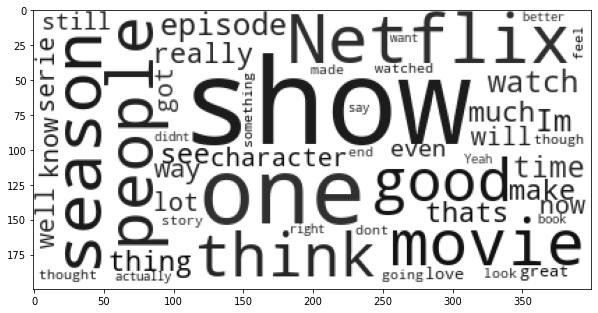

In [20]:
stp = STOPWORDS.copy()
# Can add stopwords
# stp.add("Netflix")

wc = WordCloud(background_color = "white", max_words = 50, stopwords = stp)

# Generate word cloud
wc.generate(all_text)

plt.figure(figsize = (10,20))
plt.imshow(wc.recolor(color_func = grey_color_func, random_state = 3))
plt.show()

## 2. Full Data Processing For Sentiment Analysis

Fully preparing my data (posts and comments) for Sentiment Analysis:
* Dropping empty comments + filling NaN body values
* Removing Netflix title names from the Submission title, body and comments
* Removing links
* Removing punctuation
* Removing \n, \t, etc.
* Removing stopwords
* Lemmatization

In [63]:
# Re-reading in my data
netflix_shows = pd.read_csv("netflix_titles_v2.csv")
posts = pd.read_csv("Netflix_Posts.csv")
comments = pd.read_csv("Netflix_Comments.csv")

In [64]:
posts.head()

,Submission,Netflix_Title,Genres,Body,URL,Upvotes,Time,Key
0,Netflix executives say the success of 'Bright'...,Bright,"Action & Adventure, Sci-Fi & Fantasy",NaN,https://www.reddit.com/r/netflix/comments/7t2f...,6802,2018-01-26 18:11:49,0
1,Netflix Fires Kevin Spacey from ‘House of Cards’,House of Cards,"TV Dramas, TV Thrillers",NaN,https://www.reddit.com/r/netflix/comments/7ao8...,6504,2017-11-04 15:47:43,1
2,Netflix has Cloverfield 3,Cloverfield,"Action & Adventure, Horror Movies, Sci-Fi & Fa...",Edit: Streaming starts post game,https://www.reddit.com/r/netflix/comments/7vav...,5597,2018-02-05 13:23:43,2
3,The Witcher is Netflix's highest rated series,The Witcher,"TV Action & Adventure, TV Dramas, TV Mysteries",https://www.forbes.com/sites/paultassi/2019/12...,https://www.reddit.com/r/netflix/comments/eekm...,4891,2019-12-24 02:30:46,3
4,"Netflix has won its first Oscar, for Icarus",Icarus,"Documentaries, Sports Movies",NaN,https://www.reddit.com/r/netflix/comments/8238...,4632,2018-03-05 17:03:47,4


In [65]:
posts.shape

(415, 8)

In [66]:
comments.head()

,Reply,Upvote,Time,Key
0,I didn't go into Bright expecting a cinematic ...,2079,2018-01-26 21:23:11,0
1,It was pretty good. It was a solid B. Pretty m...,1529,2018-01-26 18:59:11,0
2,"I enjoyed it, I would watch another. It did n...",244,2018-01-27 00:16:08,0
3,This is a pretty terrible argument. There no f...,25,2018-01-27 04:42:08,0
4,Everything was great about it except the plot....,149,2018-01-26 23:37:54,0


In [67]:
comments.shape

(57732, 4)

2.1 Dropping empty comments + filling NaN body values

In [68]:
comments.dropna(subset = ["Reply"], inplace = True)

# For body, I will instead fillna
posts.Body.fillna("", inplace = True)

In [69]:
# Resetting index (only columns were dropped from comments)
comments = comments.reset_index(drop = True)

2.2 Remove Netflix title from Submission title, body and comments (IMPORTANT)

In [70]:
# New list for modified "Submission"
new_submission = []

count = 0
for line in posts["Submission"]:
    new_submission.append(line.replace(posts["Netflix_Title"].tolist()[count], ""))
    count += 1

In [71]:
# Replacing "Submission" with the modified column
posts["Submission"] = new_submission

In [72]:
# New list for modified "Body"
new_body = []

count = 0
for line in posts["Body"]:
    new_body.append(line.replace(posts["Netflix_Title"].tolist()[count], ""))
    count += 1

In [73]:
# Replacing "Body" with the modified column
posts["Body"] = new_body

In [74]:
# New list for modified "Reply" (comments)
new_reply = []

count = 0
for line in comments["Reply"]:
    key = comments["Key"][count]
    new_reply.append(line.replace(posts["Netflix_Title"].tolist()[key], ""))
    count += 1

In [75]:
# Replacing "Reply" with the modified column
comments["Reply"] = new_reply

2.3 Remove links

In [76]:
posts.Submission = posts.Submission.apply(lambda x: re.sub(r"\(?http\S+", "", x))
posts.Body = posts.Body.apply(lambda x: re.sub(r"\(?http\S+", "", x))
comments.Reply = comments.Reply.apply(lambda x: re.sub(r"\(?http\S+", "", x))

2.4 Remove punctuation

In [77]:
posts.Submission = posts.Submission.apply(lambda x: re.sub(r"[^\w\s]", "", x))
posts.Body = posts.Body.apply(lambda x: re.sub(r"[^\w\s]", "", x))
comments.Reply = comments.Reply.apply(lambda x: re.sub(r"[^\w\s]", "", x))

2.5 Removing \n, \t, etc. characters that do not help with prediction, but might link 2 words together, making them indistinguishable from one another.

Again, no need to use any extra .replace() method.

In [78]:
posts.Submission = posts.Submission.apply(lambda x: " ".join(nltk.word_tokenize(x)))
posts.Body = posts.Body.apply(lambda x: " ".join(nltk.word_tokenize(x)))
comments.Reply = comments.Reply.apply(lambda x: " ".join(nltk.word_tokenize(x)))

2.6 Remove stopwords

In [79]:
from nltk.corpus import stopwords

stopwords = stopwords.words("english")
posts.Submission = posts.Submission.apply(lambda x: " ".join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
posts.Body = posts.Body.apply(lambda x: " ".join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
comments.Reply = comments.Reply.apply(lambda x: " ".join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

2.7 Lemmatization

In [80]:
lemmatizer = nltk.WordNetLemmatizer()
posts.Submission = posts.Submission.apply(lambda x: " ".join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
))
posts.Body = posts.Body.apply(lambda x: " ".join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
))
comments.Reply = comments.Reply.apply(lambda x: " ".join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
))

Now, I will write to 2 new csv's that are ready for sentiment analysis.

In [81]:
posts.to_csv("Netflix_Posts_Processed.csv", index = False)
comments.to_csv("Netflix_Comments_Processed.csv", index = False)

## 3. Sentiment Analysis

In [93]:
posts = pd.read_csv("Netflix_Posts_Processed.csv")
comments = pd.read_csv("Netflix_Comments_Processed.csv")

### 3.1 Vader

In [94]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

# Initialize Vader
sid = SentimentIntensityAnalyzer()

Creating new columns to add in the new variables. Because Vader returns a dictionary, we can just call pd.Series to add it in.

We will be looking firstly at the posts (Submission Title - decided against looking at Body).

In [95]:
# First, sentiment scores for the Submission title
posts[["neg","neu","pos","compound"]] = posts.Submission.apply(lambda x: pd.Series(sid.polarity_scores(str(x))))

In [98]:
posts.head(3)

,Submission,Netflix_Title,Genres,Body,URL,Upvotes,Time,Key,neg,neu,pos,compound,Sentiment
0,Netflix executive say success proof bad review...,Bright,"Action & Adventure, Sci-Fi & Fantasy",NaN,https://www.reddit.com/r/netflix/comments/7t2f...,6802,2018-01-26 18:11:49,0,0.25,0.547,0.202,0.0325,neutral
1,Netflix Fires Kevin Spacey,House of Cards,"TV Dramas, TV Thrillers",NaN,https://www.reddit.com/r/netflix/comments/7ao8...,6504,2017-11-04 15:47:43,1,0.00,1.000,0.000,0.0000,neutral
2,Netflix 3,Cloverfield,"Action & Adventure, Horror Movies, Sci-Fi & Fa...",Edit Streaming start post game,https://www.reddit.com/r/netflix/comments/7vav...,5597,2018-02-05 13:23:43,2,0.00,1.000,0.000,0.0000,neutral


In hindsight, far too many posts from the ones that I've gathered have an empty body - so I have decided to leave out sentiment analysis on the body of the posts.

In [86]:
# Second, sentiment scores for the Body of post
# posts[["b_neg","b_neu","b_pos","b_compound"]] = posts.Body.apply(lambda x: pd.Series(sid.polarity_scores(str(x))))

In [97]:
# Generating overall sentiment
# Positive: compound >= 0.05
# Negative: compound <= 0.05
# Neutral: in between
posts["Sentiment"] = np.where(posts["compound"] >= 0.05, "positive", np.where(posts["compound"] <= -0.05, "negative", "neutral"))

In [127]:
posts[["Submission", "Netflix_Title", "neg", "neu", "pos", "compound", "Sentiment"]]

,Submission,Netflix_Title,neg,neu,pos,compound,Sentiment
0,Netflix executive say success proof bad review...,Bright,0.250,0.547,0.202,0.0325,neutral
1,Netflix Fires Kevin Spacey,House of Cards,0.000,1.000,0.000,0.0000,neutral
2,Netflix 3,Cloverfield,0.000,1.000,0.000,0.0000,neutral
3,Netflixs highest rated series,The Witcher,0.000,1.000,0.000,0.0000,neutral
4,Netflix first Oscar,Icarus,0.000,1.000,0.000,0.0000,neutral
...,...,...,...,...,...,...,...
410,season 2 premiere May 12,Master of None,0.000,1.000,0.000,0.0000,neutral
411,Season 4 Official Trailer HD Netflix,BoJack Horseman,0.000,1.000,0.000,0.0000,neutral
412,final season coming November 2,House of Cards,0.000,1.000,0.000,0.0000,neutral
413,Striking Vipers Official Trailer,Black Mirror,0.000,1.000,0.000,0.0000,neutral


In [130]:
total = 0
count_pos = 0
count_neg = 0
count_neu = 0
for index, row in posts.iterrows():
    if row.Sentiment == "positive":
        count_pos += 1
    elif row.Sentiment == "negative":
        count_neg += 1
    elif row.Sentiment == "neutral":
        count_neu += 1
    total += 1

print("For the submission titles of the posts, \n")
    
print("The number of positive sentiments: " + str(count_pos))
print("The number of negative sentiments: " + str(count_neg))
print("The number of neutral sentiments: " + str(count_neu))
print()

print("As a percentage of the total: (415!)\n")
print(str(round(count_pos*100/total, 2)) + "% of submission titles were positive.")
print(str(round(count_neg*100/total, 2)) + "% of submission titles were negative.")
print(str(round(count_neu*100/total, 2)) + "% of submission titles were neutral.")

For the submission titles of the posts, 

The number of positive sentiments: 88
The number of negative sentiments: 70
The number of neutral sentiments: 257

As a percentage of the total: (415!)

21.2% of submission titles were positive.
16.87% of submission titles were negative.
61.93% of submission titles were neutral.


#### Thoughts on submission title sentiment scores:

It was interesting, though not very suprising that that the majority of submission titles were neutral in sentiment.

Most popular (top-voted) posts on r/Netflix seem to be news: for example, that so-and-so TV show or movie has been released, or has been renewed for a second season, or the trailer has come out.

Therefore, the submission tends to be more informative, and far less opinionated compared to the comments.

Now, for the comments.

In [119]:
# Sentiment scores for the comments
comments[["neg","neu","pos","compound"]] = comments.Reply.apply(lambda x: pd.Series(sid.polarity_scores(str(x))))

In [124]:
comments.head(3)

,Reply,Upvote,Time,Key,neg,neu,pos,compound,Sentiment
0,didnt go expecting cinematic masterpiece expec...,2079,2018-01-26 21:23:11,0,0.0,0.728,0.272,0.6249,positive
1,pretty good solid B Pretty much expected fanta...,1529,2018-01-26 18:59:11,0,0.0,0.423,0.577,0.8720,positive
2,enjoyed would watch another however change lif...,244,2018-01-27 00:16:08,0,0.0,0.519,0.481,0.7506,positive


In [123]:
# Generating overall sentiment
# Positive: compound >= 0.05
# Negative: compound <= 0.05
# Neutral: in between
comments["Sentiment"] = np.where(comments["compound"] >= 0.05, "positive", np.where(comments["compound"] <= -0.05, "negative", "neutral"))

In [129]:
comments[["Reply", "neg", "neu", "pos", "compound", "Sentiment"]]

,Reply,neg,neu,pos,compound,Sentiment
0,didnt go expecting cinematic masterpiece expec...,0.000,0.728,0.272,0.6249,positive
1,pretty good solid B Pretty much expected fanta...,0.000,0.423,0.577,0.8720,positive
2,enjoyed would watch another however change lif...,0.000,0.519,0.481,0.7506,positive
3,pretty terrible argument friction watching mov...,0.258,0.518,0.225,-0.5915,negative
4,Everything great except plot whole modern fair...,0.089,0.613,0.298,0.8901,positive
...,...,...,...,...,...,...
57724,think different subchannel BBC subchannel AMC ...,0.031,0.684,0.285,0.9313,positive
57725,Im sure youre saying first paragraph,0.000,0.685,0.315,0.3182,positive
57726,Im saying BBC America isnt like Netflix like N...,0.187,0.710,0.102,-0.2311,negative
57727,BBC America produced coproduced whole bunch or...,0.000,0.694,0.306,0.5267,positive


In [131]:
total = 0
count_pos = 0
count_neg = 0
count_neu = 0
for index, row in comments.iterrows():
    if row.Sentiment == "positive":
        count_pos += 1
    elif row.Sentiment == "negative":
        count_neg += 1
    elif row.Sentiment == "neutral":
        count_neu += 1
    total += 1

print("For the comments of the posts, \n")
    
print("The number of positive sentiments: " + str(count_pos))
print("The number of negative sentiments: " + str(count_neg))
print("The number of neutral sentiments: " + str(count_neu))
print()

print("As a percentage of the total: (57729!)\n")
print(str(round(count_pos*100/total, 2)) + "% of submission titles were positive.")
print(str(round(count_neg*100/total, 2)) + "% of submission titles were negative.")
print(str(round(count_neu*100/total, 2)) + "% of submission titles were neutral.")

For the comments of the posts, 

The number of positive sentiments: 28812
The number of negative sentiments: 14013
The number of neutral sentiments: 14904

As a percentage of the total: (57729!)

49.91% of submission titles were positive.
24.27% of submission titles were negative.
25.82% of submission titles were neutral.


#### Thoughts on comment sentiment scores:

This is perhaps what I expected, for there to be a larger proportion of positive sentiment per comment compared to the more neutral, less opinionated submission titles.

However, I did not expect 50% of sentiment to be positive. I had expected generally more, specifically since these were top posts based around a single title - these posts are upvoted and heavily discussed because viewers are interested / invested in the title.

It is also of interest to note, that posts centred around a single title are unlike the other top posts, which are normally upvoted heavily because it discusses a contraversial topic - such as the possibility of Netflix bringing in advertisements.

In [133]:
posts.to_csv("Netflix_Posts_Sentiment.csv", index = False)
comments.to_csv("Netflix_Comments_Sentiment.csv", index = False)

## 4. Genre

In [148]:
posts = pd.read_csv("Netflix_Posts_Sentiment.csv")
comments = pd.read_csv("Netflix_Comments_Sentiment.csv")

In [149]:
# Renaming posts.Sentiment to "Submission_Sentiment"
posts["Submission_Sentiment"] = posts["Sentiment"]

In [150]:
# Dropping some columns
posts.drop(columns = ["neg", "neu", "pos", "Sentiment"], inplace = True)

Making a comment aggregate compound score for each post (key).

In [172]:
# Summing up total compound scores for each post (key)
comment_aggregate_compound = [0] * len(posts.Submission_Sentiment)

count = 0
for key in comments["Key"]:
    comment_aggregate_compound[key] += comments["compound"][count]
    count += 1

In [179]:
# Counting up how many comments per post (key)
comment_per_post = [0] * len(posts.Submission_Sentiment)

keys = comments["Key"].tolist()

for key in keys:
    comment_per_post[key] += 1

In [183]:
# New list for aggregate sentiment
comment_aggregate_sentiment = [0] * len(posts.Submission_Sentiment)

comment_aggregate_sentiment = [int(b) / int(m) for b,m in zip(comment_aggregate_compound, comment_per_post)]

In [186]:
posts["Comment_Aggregate_Compound"] = comment_aggregate_sentiment

In [189]:
posts

,Submission,Netflix_Title,Genres,Body,URL,Upvotes,Time,Key,compound,Submission_Sentiment,Comment_Aggregate_Compound
0,Netflix executive say success proof bad review...,Bright,"Action & Adventure, Sci-Fi & Fantasy",NaN,https://www.reddit.com/r/netflix/comments/7t2f...,6802,2018-01-26 18:11:49,0,0.0325,neutral,0.105263
1,Netflix Fires Kevin Spacey,House of Cards,"TV Dramas, TV Thrillers",NaN,https://www.reddit.com/r/netflix/comments/7ao8...,6504,2017-11-04 15:47:43,1,0.0000,neutral,-0.072430
2,Netflix 3,Cloverfield,"Action & Adventure, Horror Movies, Sci-Fi & Fa...",Edit Streaming start post game,https://www.reddit.com/r/netflix/comments/7vav...,5597,2018-02-05 13:23:43,2,0.0000,neutral,0.131818
3,Netflixs highest rated series,The Witcher,"TV Action & Adventure, TV Dramas, TV Mysteries",Obviously still drop couple point likely still...,https://www.reddit.com/r/netflix/comments/eekm...,4891,2019-12-24 02:30:46,3,0.0000,neutral,0.229483
4,Netflix first Oscar,Icarus,"Documentaries, Sports Movies",NaN,https://www.reddit.com/r/netflix/comments/8238...,4632,2018-03-05 17:03:47,4,0.0000,neutral,0.151786
...,...,...,...,...,...,...,...,...,...,...,...
410,season 2 premiere May 12,Master of None,TV Comedies,NaN,https://www.reddit.com/r/netflix/comments/5zkl...,631,2017-03-16 06:03:06,410,0.0000,neutral,0.347826
411,Season 4 Official Trailer HD Netflix,BoJack Horseman,TV Comedies,NaN,https://www.reddit.com/r/netflix/comments/6vri...,627,2017-08-25 03:15:41,411,0.0000,neutral,0.219512
412,final season coming November 2,House of Cards,"TV Dramas, TV Thrillers",NaN,https://www.reddit.com/r/netflix/comments/95c0...,624,2018-08-08 02:15:57,412,0.0000,neutral,0.036765
413,Striking Vipers Official Trailer,Black Mirror,"British TV Shows, International TV Shows, TV D...",NaN,https://www.reddit.com/r/netflix/comments/brbc...,622,2019-05-22 02:52:45,413,0.0000,neutral,0.111111


#### Sadly, I was not able to finish on time, for aggregate comment sentiment, as well as analysing by Genre.

## 5. Problems I faced

Sentiment analysis is far too subjective when it comes to humans. Often times we can make statements that, after considering the traditionally positive/negative terms, are actually presented with the opposite sentiment in mind. The context of a post/comment a highly important factor in determining true sentiment.

For example, reddit users use an /s to denote sarcasm (something that should be obvious depending on the context, not obvious in a sentiment analysis process).

Also, certain statements like: “We should build a wall to protect Americans from Mexicans trying to enter across the border. This will be viewed as a positive and helpful statement by some people, and for others this will be a negative and terrifying proposition.

## 6. Other considerations

Another use of sentiment analysis for Netflix I thought about was to gauge sentiments on new changes to the platform that Netflix was thinking of making, and before making that change they could look first to the Reddit community to see their sentiment on such proposals effectively gauging their reaction before the change is even made. For example, if Netflix was considering to add commercials and advertisements to their streaming platform, they can filter posts and comments by keywords such as commercials, ads, advertisements, and can get a good sentiment read on it.